In [1]:
import pandas as pd
final_dataset=pd.read_csv("cognitive_load_score.csv")
final_dataset.head(15)

,timestamp,ACC_ACC_X,ACC_ACC_Y,ACC_ACC_Z,BVP_BVP,EDA_EDA,HR_HR,IBI_value,TEMP_TEMP,Cognitive_Load,Participant,Experiment,Hand
0,2021-06-21 07:56:17,-49.43750,-3.37500,43.81250,15.760000,0.271659,55.0,0.671875,32.79,NaN,A1,Experiment_1,Left
1,2021-06-21 07:56:18,-49.96875,-3.37500,42.84375,-44.364375,0.397557,55.0,0.671875,32.79,NaN,A1,Experiment_1,Left
2,2021-06-21 07:56:19,-62.53125,7.06250,19.81250,31.496250,0.402042,55.0,0.671875,32.79,NaN,A1,Experiment_1,Left
3,2021-06-21 07:56:20,-64.65625,10.59375,9.62500,-1.485469,0.410691,55.0,0.671875,32.79,NaN,A1,Experiment_1,Left
4,2021-06-21 07:56:21,-62.46875,3.40625,21.40625,-2.964688,0.411652,55.0,0.671875,32.77,NaN,A1,Experiment_1,Left
5,2021-06-21 07:56:22,-61.40625,-10.25000,-15.90625,3.801094,0.341175,55.0,0.671875,32.75,NaN,A1,Experiment_1,Left
6,2021-06-21 07:56:23,-61.03125,-8.46875,-2.50000,3.504844,0.316508,55.0,0.671875,32.77,NaN,A1,Experiment_1,Left
7,2021-06-21 07:56:24,-57.00000,-0.15625,32.37500,-23.820312,0.344058,55.0,0.671875,32.75,NaN,A1,Experiment_1,Left
8,2021-06-21 07:56:25,-51.46875,0.09375,41.68750,24.328125,0.390830,55.0,0.671875,32.73,NaN,A1,Experiment_1,Left
9,2021-06-21 07:56:26,-23.31250,-25.84375,35.68750,-2.311562,0.375132,55.0,0.671875,32.77,NaN,A1,Experiment_1,Left


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization,
    TimeDistributed, Flatten, Multiply, Softmax, Lambda, Bidirectional
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow.keras.backend as K
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add

In [3]:
# ---------------- STEP 1: Preprocess ---------------- #
final_dataset = final_dataset.dropna(subset=["Cognitive_Load"]).reset_index(drop=True)

feature_cols = [
    "BVP_BVP", "EDA_EDA", "HR_HR",
    "IBI_value", "TEMP_TEMP"
]

# Normalize features
scaler = StandardScaler()
final_dataset[feature_cols] = scaler.fit_transform(final_dataset[feature_cols])

# ---------------- STEP 2: Create sliding windows ---------------- #
def create_windows(df, feature_cols, window_size=60, stride=30):
    X, y = [], []
    data = df[feature_cols].values
    labels = df["Cognitive_Load"].values

    for start in range(0, len(df) - window_size + 1, stride):
        end = start + window_size
        X_window = data[start:end]
        y_window = labels[start:end]
        X.append(X_window)
        y.append(np.mean(y_window))  # cognitive load label
    return np.array(X), np.array(y)

X, y = create_windows(final_dataset, feature_cols)

print("X shape:", X.shape)
print("y shape:", y.shape)

# ---------------- STEP 3: Group windows into sequences ---------------- #
def create_sequences(X, y, seq_len=5):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - seq_len + 1, seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(np.max(y[i:i+seq_len]))  # sequence-level label
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, seq_len=5)
print("X_seq shape:", X_seq.shape)  # (num_sequences, 5, 60, num_features)

# ---------------- STEP 4: Train-test split ---------------- #
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

X shape: (7020, 60, 5)
y shape: (7020,)
X_seq shape: (1404, 5, 60, 5)


In [4]:

# ---------------- STEP 5: Attention Block ---------------- #
def attention_block(inputs):
    """
    Applies attention over time dimension (for LSTM outputs).
    """
    attn_scores = Dense(1, activation='tanh')(inputs)
    attn_scores = Softmax(axis=1)(attn_scores)
    context_vector = Multiply()([inputs, attn_scores])
    context_vector = Lambda(lambda x: K.sum(x, axis=1))(context_vector)
    return context_vector

# ---------------- STEP 6: Hierarchical Model ---------------- #
def create_hierarchical_model(input_shape):
    """
    Two-level hierarchical model:
    - Level 1 (intra-window): CNN + LSTM + Attention inside each window.
    - Level 2 (inter-window): LSTM across window embeddings.
    """
    # Input shape = (num_windows, window_size, num_features)
    input_layer = Input(shape=input_shape)

    # Level 1: feature extractor (per window)
    def intra_window_module():
        i = Input(shape=(input_shape[1], input_shape[2]))
        x = Conv1D(64, 5, activation='relu', padding='same')(i)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = Dropout(0.3)(x)

        x = Conv1D(128, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = Dropout(0.3)(x)

        x = LSTM(64, return_sequences=True)(x)
        x = attention_block(x)
        return Model(i, x)

    intra_window = intra_window_module()

    # Apply the intra-window model to each window (TimeDistributed)
    x = TimeDistributed(intra_window)(input_layer)

    # Level 2: Inter-window LSTM (sequence across windows)
    #x = Bidirectional(LSTM(128, return_sequences=True))(x)
    #x = attention_block(x)
    # BiLSTM + Transformer encoder block
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(x)
    attn_out = MultiHeadAttention(num_heads=4, key_dim=64)(lstm_out, lstm_out)
    attn_out = Add()([lstm_out, attn_out])  # residual
    attn_out = LayerNormalization()(attn_out)
    x = attention_block(attn_out)
    x = Dropout(0.4)(x)

    # Dense layers for regression
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='mse',
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = create_hierarchical_model(input_shape)
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 60, 5)]           0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 5, 64)                76609     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 bidirectional (Bidirection  (None, 5, 256)               197632    ['time_distributed[0][0]']    
 al)                                                                                              
                                                                                          

In [5]:

# ---------------- STEP 7: Callbacks ---------------- #
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_hierarchical_attention_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1)

# ---------------- STEP 8: Train ---------------- #
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping, checkpoint, lr_reducer],
    verbose=1
)

Epoch 1/100


112/113 [============================>.] - ETA: 0s - loss: 0.5064 - mae: 0.5491 - rmse: 0.7116
Epoch 1: val_loss improved from inf to 0.18102, saving model to best_hierarchical_attention_model.keras
113/113 [==============================] - 13s 50ms/step - loss: 0.5056 - mae: 0.5487 - rmse: 0.7110 - val_loss: 0.1810 - val_mae: 0.3674 - val_rmse: 0.4255 - lr: 5.0000e-04
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 0.1171 - mae: 0.2688 - rmse: 0.3422
Epoch 2: val_loss improved from 0.18102 to 0.11602, saving model to best_hierarchical_attention_model.keras
113/113 [==============================] - 3s 30ms/step - loss: 0.1171 - mae: 0.2688 - rmse: 0.3422 - val_loss: 0.1160 - val_mae: 0.3085 - val_rmse: 0.3406 - lr: 5.0000e-04
Epoch 3/100
112/113 [============================>.] - ETA: 0s - loss: 0.0716 - mae: 0.2118 - rmse: 0.2676
Epoch 3: val_loss improved from 0.11602 to 0.08321, saving model to best_hierarchical_attention_model.keras
113/113 [=

9/9 [==============================] - 3s 25ms/step

📊 Model Evaluation:
MSE: 0.0056
MAE: 0.0598
R² Score: 0.3367


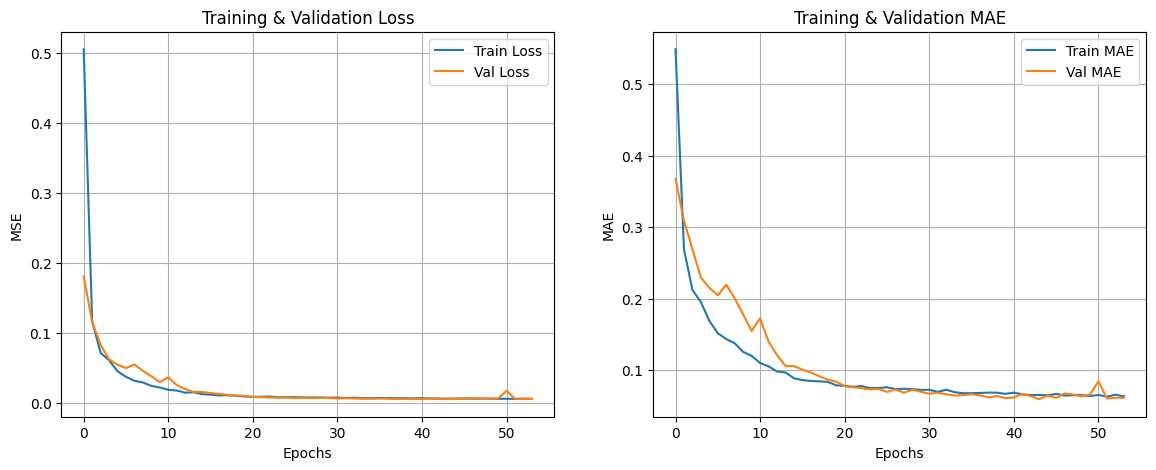

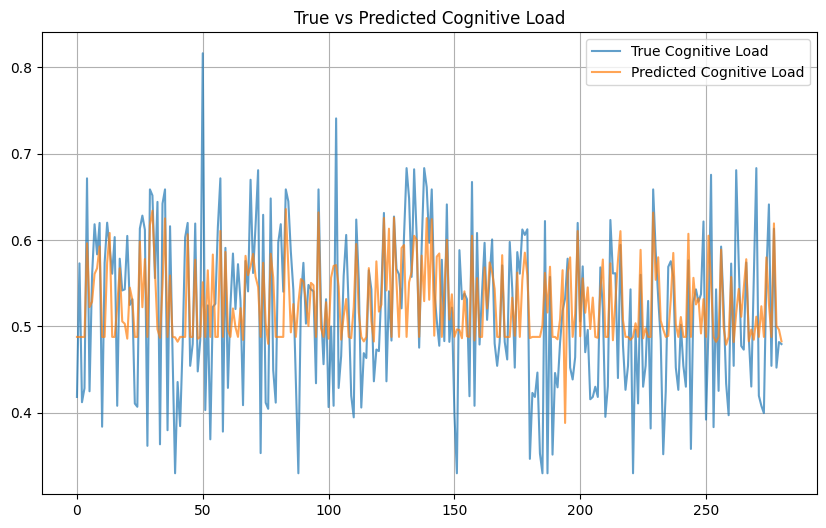

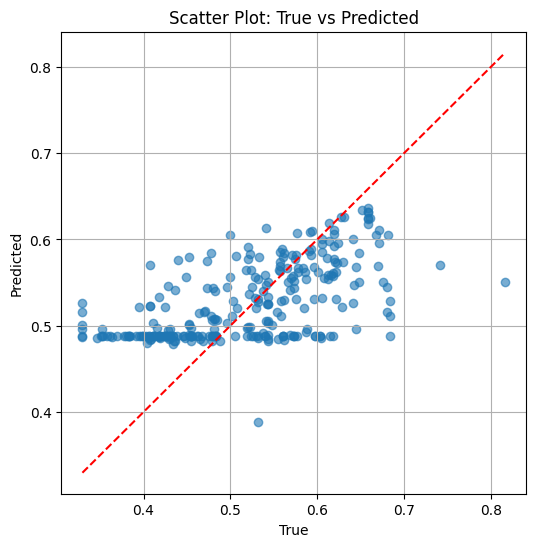

In [6]:

# ---------------- STEP 9: Evaluate ---------------- #
y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# ---------------- STEP 10: Visualization ---------------- #
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('MSE'); plt.title('Training & Validation Loss')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs'); plt.ylabel('MAE'); plt.title('Training & Validation MAE')
plt.legend(); plt.grid(True)
plt.show()

# Predictions vs True
plt.figure(figsize=(10,6))
plt.plot(y_test, label="True Cognitive Load", alpha=0.7)
plt.plot(y_pred, label="Predicted Cognitive Load", alpha=0.7)
plt.legend(); plt.grid(True)
plt.title("True vs Predicted Cognitive Load")
plt.show()

# Scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True"); plt.ylabel("Predicted")
plt.title("Scatter Plot: True vs Predicted")
plt.grid(True)
plt.show()
